In [1]:
import glob
import os.path
import pickle
import shutil
import zipfile

import matplotlib.pyplot
import numpy
import pandas
import skimage.io
import skimage.measure
import skimage.segmentation
import warnings

warnings.filterwarnings("ignore")

import tqdm

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Auxiliary functions

In [2]:
def archive_to_csv(pathname):
    _, directory = os.path.split(pathname)

    directory, _ = os.path.splitext(directory)

    directory = os.path.join("/tmp", "DSB2018", directory)

    with zipfile.ZipFile(pathname, "r") as stream:
        names = stream.namelist()

        # Test whether the archive has _exactly_ one name:
        assert len(names) == 1

        name = names.pop()

        pathname = os.path.join(directory, name)

#         try:
        stream.extractall(directory)

        # Test whether the archive was _successfully_ extracted:
        assert os.path.exists(pathname)

        scores = pandas.read_csv(pathname)
#         finally:
#             directory = os.path.join("/tmp", "DSB2018")

#             shutil.rmtree(directory)
    
    return scores

def decode(encoded, shape):
    r, c = shape

    if str(encoded) == 'nan':
        return None
    
    encoded = encoded.replace("[", "").replace("]", "").replace(",", " ")
    encoded = [int(instance) for instance in encoded.split(" ") if instance != '']

    image = numpy.zeros(r * c, dtype=numpy.uint8)

    for index, size in numpy.array(encoded).reshape(-1, 2):
        index -= 1

        image[index:index + size] = 255

    return image.reshape(c, r).transpose()

def label_objects(mask_objects, shape):
    labels = numpy.zeros(shape, numpy.uint16)

    for index, mask_object in enumerate(mask_objects.itertuples()):
        decoded = decode(mask_object.EncodedPixels, shape)
        if decoded is not None:
            labels[decoded == 255] = index + 1
        
    return labels

# Load metadata

In [3]:
shapes = pandas.read_csv("/storage/data/DSB2018/metadata/shapes.csv")

In [4]:
submissions = pandas.read_csv("/storage/data/DSB2018/metadata/submissions.csv")

submissions = submissions[submissions["score"] > 0]

submissions["max_score"] = submissions.groupby(["team"])["score"].transform(max)

submissions["best_submission"] = submissions["max_score"] == submissions["score"]

submissions = submissions[submissions["best_submission"]]

In [5]:
pathname = os.path.join("/storage/data/DSB2018/submissions", f"{str(submissions['id'][0])}.zip")

masks = archive_to_csv(pathname)

y_true_pathnames = glob.glob("/storage/data/DSB2018/phase-2-gt/*.png")

y_true_identifiers = [os.path.splitext(os.path.basename(pathname))[0] for pathname in y_true_pathnames]

masks = masks[masks["ImageId"].isin(y_true_identifiers)]

In [6]:
y_true_pathnames = [os.path.basename(pathname) for pathname in glob.glob("/storage/data/DSB2018/phase-2-gt/*.png")]

# Visualize example images

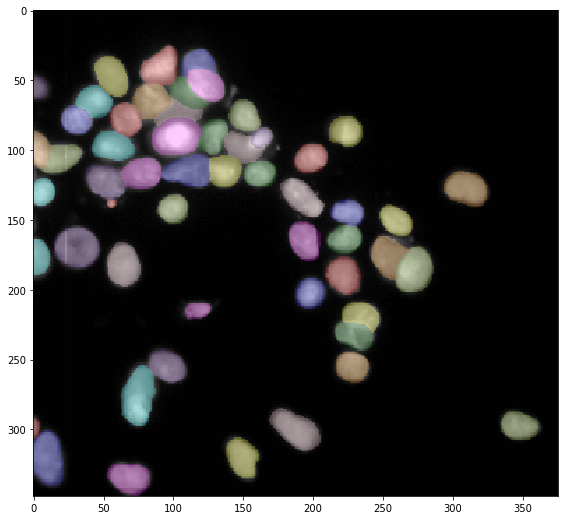

In [7]:
index = 44

image = skimage.io.imread("/storage/data/DSB2018/phase-2-imgs/{}".format(y_true_pathnames[index]))

image = skimage.exposure.equalize_adapthist(image)

label = skimage.io.imread("/storage/data/DSB2018/phase-2-gt/{}".format(y_true_pathnames[index]))

label = skimage.measure.label(label)

matplotlib.pyplot.figure(figsize=(8, 8))

matplotlib.pyplot.set_cmap("coolwarm")

skimage.io.imshow(skimage.color.label2rgb(label, image, alpha=0.2, bg_label=0))

In [8]:
numpy.unique(label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54])

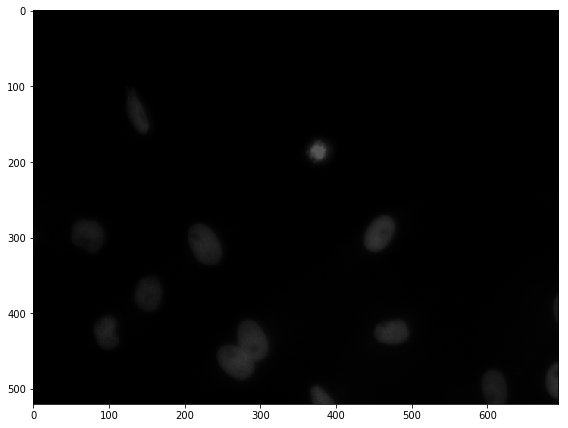

In [9]:
matplotlib.pyplot.figure(figsize=(8, 8))

skimage.io.imshow("/storage/data/DSB2018/phase-2-imgs/6cac54fefe515d19363e6da44f5800535fc9bd6f215765bb73c0f3cdd918d20f.png")

# Decode submissions

In [10]:
submissions["Done"] = False

In [11]:
errors = 0

for submiss in tqdm.tqdm(submissions.itertuples()):
    submission = submiss.id
    
    if submissions.loc[submiss.Index, "Done"]:
        print(submission, "done")
        continue
    
    pathname = os.path.join("/storage/data/DSB2018/submissions", f"{str(submission)}.zip")

    try:
        masks = archive_to_csv(pathname)
    except Exception as error:
        print("Error with", pathname)
        print(error)
        continue

    y_true_pathnames = glob.glob("/storage/data/DSB2018/phase-2-gt/*.png")

    y_true_identifiers = [os.path.splitext(os.path.basename(pathname))[0] for pathname in y_true_pathnames]

    if "ImageId" in masks.columns:
        idcol = "ImageId"
    elif "ImageID" in masks.columns:
        idcol = "ImageID"
        
    masks = masks[masks[idcol].isin(y_true_identifiers)]

    for y_true_identifier in y_true_identifiers:
        shape = shapes[shapes["name"] == y_true_identifier]

        shape = (int(shape["r"]), int(shape["c"]))

        mask_objects = masks[masks[idcol] == y_true_identifier]

        try:
            labels = label_objects(mask_objects, shape)
        except Exception as error:
            print("error {}: {}".format(y_true_identifier, error))
            labels = numpy.zeros(shape, numpy.uint16)
            errors += 1

        filename = "{}-{}.png".format(submission, y_true_identifier)

        pathname = os.path.join("/storage/data/DSB2018/phase-2-predictions/", filename)

        skimage.io.imsave(pathname, labels)
    
    submissions.loc[submiss.Index, "Done"] = True
        
print("Errors:", errors)

65it [02:58,  2.74s/it]

Error with /storage/data/DSB2018/submissions/7211045.zip
'utf-8' codec can't decode byte 0xbc in position 2: invalid start byte
Error with /storage/data/DSB2018/submissions/7191594.zip
'utf-8' codec can't decode byte 0xbc in position 2: invalid start byte


119it [05:28,  2.76s/it]

Error with /storage/data/DSB2018/submissions/7203370.zip
'utf-8' codec can't decode byte 0xbc in position 2: invalid start byte


125it [05:43,  2.75s/it]

Error with /storage/data/DSB2018/submissions/7178565.zip
'utf-8' codec can't decode byte 0xbc in position 2: invalid start byte


156it [07:20,  2.83s/it]

Error with /storage/data/DSB2018/submissions/7210925.zip
('Multiple files found in compressed zip file %s', "['submit_stage2_test.csv', '__MACOSX/', '__MACOSX/._submit_stage2_test.csv']")


170it [08:00,  2.82s/it]

Error with /storage/data/DSB2018/submissions/7217213.zip
'utf-8' codec can't decode byte 0xbc in position 2: invalid start byte


193it [09:00,  2.80s/it]

Error with /storage/data/DSB2018/submissions/7217679.zip
'utf-8' codec can't decode byte 0xbc in position 2: invalid start byte


195it [09:02,  2.78s/it]

Error with /storage/data/DSB2018/submissions/7177002.zip
Error tokenizing data. C error: Expected 1 fields in line 5, saw 2



206it [09:30,  2.77s/it]

Error with /storage/data/DSB2018/submissions/7209135.zip
'utf-8' codec can't decode byte 0xbc in position 2: invalid start byte


252it [11:53,  2.83s/it]

error a04b569f7fda650fddaa7d2945cf8a2fe7f3356883ac3353c6dcab5b3816ff56: invalid literal for int() with base 10: '""'


256it [12:06,  2.84s/it]

Error with /storage/data/DSB2018/submissions/7190277.zip
'utf-8' codec can't decode byte 0xbc in position 2: invalid start byte


410it [19:28,  2.85s/it]

Error with /storage/data/DSB2018/submissions/7217876.zip
('Multiple files found in compressed zip file %s', "['sub_epoch22.csv', '__MACOSX/', '__MACOSX/._sub_epoch22.csv']")
Error with /storage/data/DSB2018/submissions/7217823.zip
('Multiple files found in compressed zip file %s', "['sub_epoch21.csv', '__MACOSX/', '__MACOSX/._sub_epoch21.csv']")


413it [19:31,  2.84s/it]

Error with /storage/data/DSB2018/submissions/7203872.zip
'utf-8' codec can't decode byte 0xbc in position 2: invalid start byte


419it [19:48,  2.84s/it]

Error with /storage/data/DSB2018/submissions/7213298.zip
Error tokenizing data. C error: Expected 1 fields in line 5, saw 2



461it [21:44,  2.83s/it]

Error with /storage/data/DSB2018/submissions/7196268.zip
'utf-8' codec can't decode byte 0xbc in position 2: invalid start byte


478it [22:37,  2.84s/it]

Error with /storage/data/DSB2018/submissions/7186125.zip
'utf-8' codec can't decode byte 0xbc in position 2: invalid start byte


480it [22:40,  2.83s/it]

error 522ce42064ddfc4a0e6469ba6384b3b052da41ba26ce59f06560f9204e86bee8: invalid literal for int() with base 10: '...'
error 66763f3cf8a5e21263a7e9de483bc2fd26409cc6caa3f918d93a10187a7ba2be: invalid literal for int() with base 10: '...'
error f06c37296d4255a51d5f85a2a4f09e68f45a35303ed0145cd630b36fef00f08b: invalid literal for int() with base 10: '...'


481it [22:42,  2.83s/it]

error 421a360cad406c179d1de83a5d0da1ef7e57dde1b502815884aec7f9cdf97c03: invalid literal for int() with base 10: '...'


552it [26:42,  2.90s/it]

Error with /storage/data/DSB2018/submissions/7216081.zip
'utf-8' codec can't decode byte 0xbc in position 2: invalid start byte


567it [27:30,  2.91s/it]

Error with /storage/data/DSB2018/submissions/7185397.zip
'utf-8' codec can't decode byte 0xbc in position 2: invalid start byte


621it [30:34,  2.95s/it]

Error with /storage/data/DSB2018/submissions/7216888.zip
'utf-8' codec can't decode byte 0xbc in position 2: invalid start byte


661it [32:41,  2.97s/it]

Error with /storage/data/DSB2018/submissions/7209774.zip
'utf-8' codec can't decode byte 0xbc in position 2: invalid start byte
Error with /storage/data/DSB2018/submissions/7215430.zip
('Multiple files found in compressed zip file %s', "['dsbowl_submission.csv', '__MACOSX/', '__MACOSX/._dsbowl_submission.csv']")


724it [37:04,  3.07s/it]

Error with /storage/data/DSB2018/submissions/7204491.zip
Error tokenizing data. C error: Expected 1 fields in line 4, saw 2

Error with /storage/data/DSB2018/submissions/7204366.zip
Error tokenizing data. C error: Expected 1 fields in line 4, saw 2



755it [39:09,  3.11s/it]

Error with /storage/data/DSB2018/submissions/7217260.zip
'utf-8' codec can't decode byte 0xbc in position 2: invalid start byte


790it [42:23,  3.22s/it]

Error with /storage/data/DSB2018/submissions/7204974.zip
'utf-8' codec can't decode byte 0xbc in position 2: invalid start byte


797it [42:36,  3.21s/it]

Error with /storage/data/DSB2018/submissions/7217660.zip
compression type 9 (deflate64)


806it [42:54,  3.19s/it]

Error with /storage/data/DSB2018/submissions/7197851.zip
'utf-8' codec can't decode byte 0xbc in position 2: invalid start byte


812it [43:17,  3.20s/it]

Errors: 5
